# Importation biliothèques

In [1]:
import pandas as pd
from math import floor
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from math import floor
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy import stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder
import psycopg2
import yaml
from sklearn.model_selection import cross_val_score #score evaluation 
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Chargement des données

In [2]:
with open(r'.\project_config.yml') as file:
    dbInfo = yaml.load(file, Loader=yaml.FullLoader)
    DB_HOST = dbInfo["project-database"]["hostname"]
    DB_NAME = dbInfo["project-database"]["name"]
    DB_USER = dbInfo["project-database"]["user"]
    DB_PASSWORD = dbInfo["project-database"]["password"]

In [3]:
table_bdf = "epa_bdf_normalisation"
table_emission = "epa_emission_normalisation"
table_merge = "bdd_emission_bdf"
try:
    connection = psycopg2.connect(user = DB_USER,
                                  password = DB_PASSWORD,
                                  host = DB_HOST,
                                  port = "5432",
                                  database = DB_NAME)
    cursor = connection.cursor()

    query1 = """SELECT * FROM public.""" + table_bdf +""" ;"""
    query2 = """SELECT * FROM public.""" + table_emission +""" ;"""
    query3 = """SELECT * FROM public.""" + table_merge +""" ;"""
    cursor.execute(query1)
    record_epa_bdf = cursor.fetchall()
    columns_bdf = cursor.description

    cursor.execute(query2)
    record_epa_emission = cursor.fetchall()
    columns_emission = cursor.description

    cursor.execute(query3)
    record_merge = cursor.fetchall()
    columns_merge = cursor.description

    print("DONE")
except (Exception, psycopg2.Error) as error :
    print ("Error while connecting to PostgreSQL", error)
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

DONE
PostgreSQL connection is closed


In [4]:
columns_epa_bdf = [col[0] for col in columns_bdf]
df_epa_bdf = pd.DataFrame(columns=columns_epa_bdf, data= record_epa_bdf)

columns_epa_emission = [col[0] for col in columns_emission]
df_epa_emission = pd.DataFrame(columns=columns_epa_emission, data= record_epa_emission)

columns_merges_total = [col[0] for col in columns_merge]
df_merge = pd.DataFrame(columns=columns_merges_total, data= record_merge)

In [5]:
PCDD = ['2378-TCDD', '12378-PeCDD', '123478-HxCDD', '123678-HxCDD',
       '123789-HxCDD', '1234678-HpCDD', 'OCDD']

PCDF = ['2378-TCDF', '12378-PeCDF',
       '23478-PeCDF', '123478-HxCDF', '123678-HxCDF',
       '123789-HxCDF', '234678-HxCDF', '1234678-HpCDF', '1234789-HpCDF', 'OCDF']

PCDD_A = [sub + "_A" for sub in PCDD]
PCDF_A = [sub + "_A" for sub in PCDF]

## Chargement des variables

In [6]:
list_columns_id = ["file", "test date", "run id", "source category", "source subcategory"]

substances = ['2378-TCDD', '12378-PeCDD', '123478-HxCDD', '123678-HxCDD',
       '123789-HxCDD', '1234678-HpCDD', 'OCDD', '2378-TCDF', '12378-PeCDF',
       '23478-PeCDF', '123478-HxCDF', '123678-HxCDF', '234678-HxCDF',
       '123789-HxCDF', '1234678-HpCDF', '1234789-HpCDF', 'OCDF']

total_homologue = ['Total TCDD', 'Total TCDF',
         'Total PCDD', 'Total PeCDF',
         'Total HxCDD', 'Total HxCDF',
         'Total HpCDD', 'Total HpCDF',
         'OCDD', 'OCDF']

total = ['Total DIOXINE', 'Total FURANE', 'Total DIOXINE FURANE']

In [7]:
PRO_A = [sub + '_A' for sub in substances]
PRO_C = [sub + '_C' for sub in substances]

## LDA (2 à 2)

In [8]:
area1 = "Rural"
area2 = "Urban"
df_methodeA = df_epa_bdf.copy()
df_analyse_final = df_methodeA.copy()
X = df_analyse_final[(df_analyse_final["Type"] == area1) | (df_analyse_final["Type"] == area2)][PRO_A]
y = df_analyse_final[(df_analyse_final["Type"] == area1) | (df_analyse_final["Type"] == area2)]["Type"]
list_areas = pd.unique(y)
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
label_dict = {i : area for i, area in enumerate(list_areas)}

In [9]:
sklearn_lda = LDA(n_components=1)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

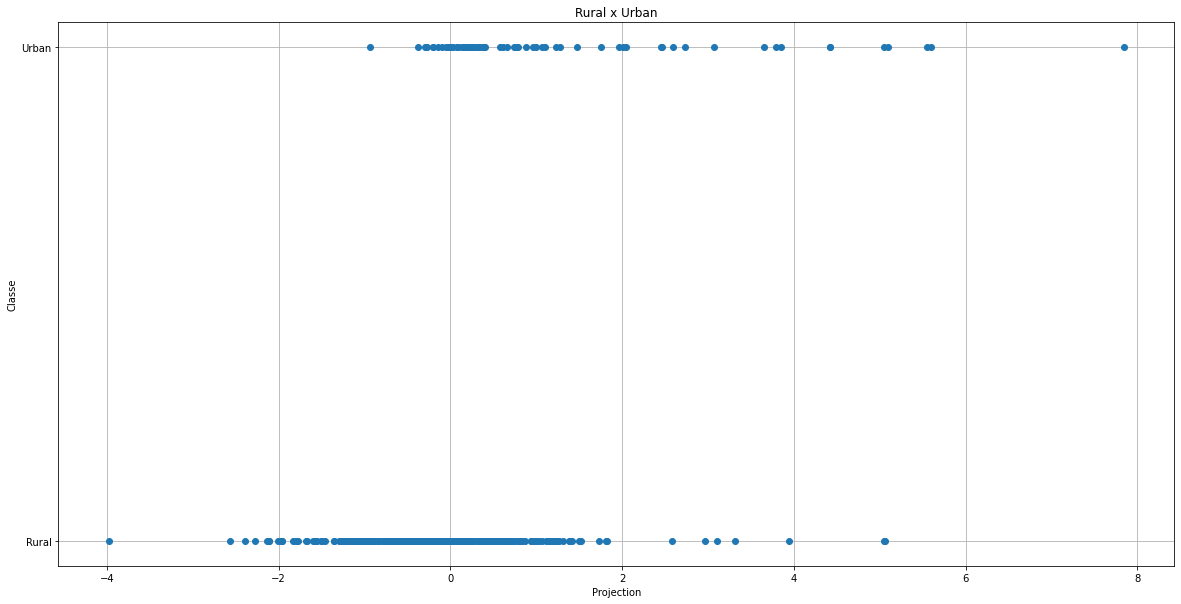

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(X_lda_sklearn, df_analyse_final[(df_analyse_final["Type"] == area1) | (df_analyse_final["Type"] == area2)]["Type"], 'o')
plt.title(area1 + " x " + area2)
plt.xlabel("Projection")
plt.ylabel("Classe")
plt.grid()
plt.show()


precision    recall  f1-score   support

       Rural       0.89      0.98      0.93       484
       Urban       0.50      0.16      0.24        69

    accuracy                           0.88       553
   macro avg       0.70      0.57      0.59       553
weighted avg       0.84      0.88      0.85       553



[Text(0, 0.5, 'Rural'), Text(0, 1.5, 'Urban')]

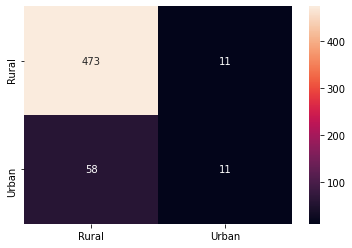

In [11]:
ax= plt.subplot()
y_pred = cross_val_predict(sklearn_lda,X,y,cv=10)
print(classification_report(y, y_pred, target_names=[label_dict[i] for i in label_dict]))
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='2.0f', ax = ax)
ax.xaxis.set_ticklabels([label_dict[i] for i in label_dict])
ax.yaxis.set_ticklabels([label_dict[i] for i in label_dict])

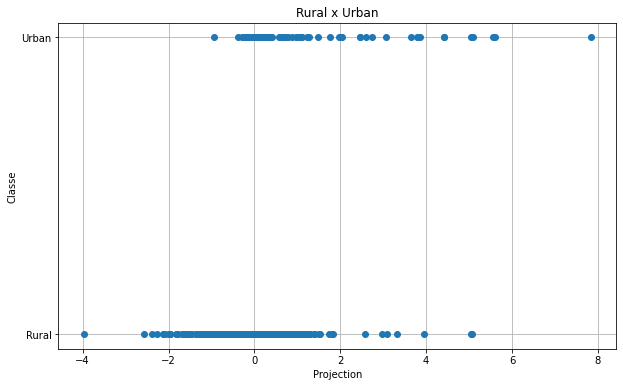

precision    recall  f1-score   support

       Rural       0.89      0.98      0.93       484
       Urban       0.50      0.16      0.24        69

    accuracy                           0.88       553
   macro avg       0.70      0.57      0.59       553
weighted avg       0.84      0.88      0.85       553



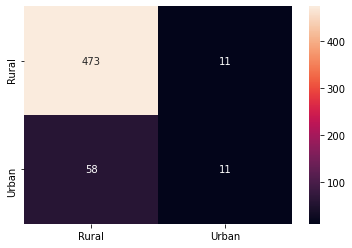

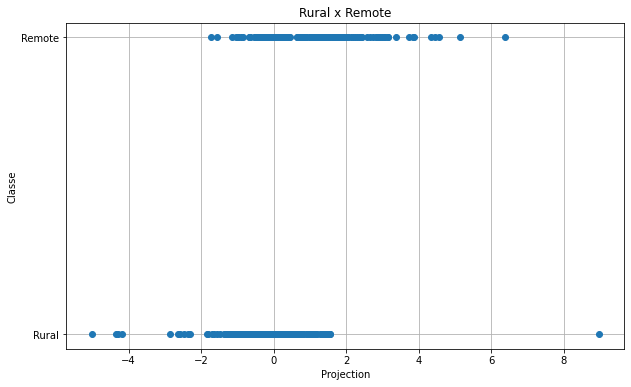

precision    recall  f1-score   support

      Remote       0.59      0.28      0.38       131
       Rural       0.83      0.95      0.88       484

    accuracy                           0.80       615
   macro avg       0.71      0.61      0.63       615
weighted avg       0.78      0.80      0.78       615



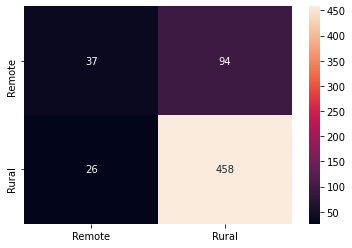

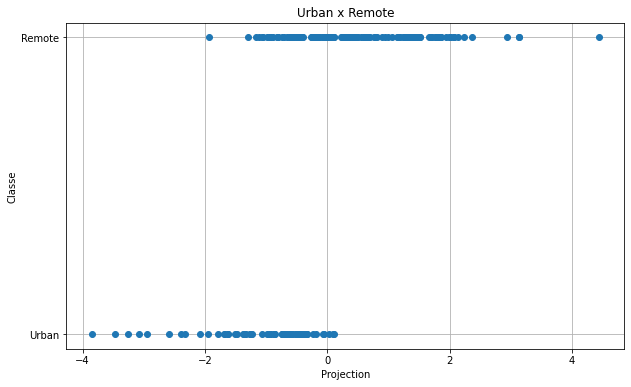

precision    recall  f1-score   support

      Remote       0.78      0.78      0.78       131
       Urban       0.58      0.58      0.58        69

    accuracy                           0.71       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.71      0.71      0.71       200



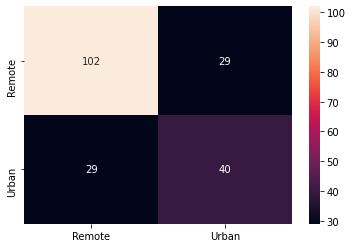

In [12]:
list_areas = pd.unique(df_methodeA["Type"])
for (i, area_i) in enumerate(list_areas):
    for (j, area_j) in enumerate(list_areas):
        if (i < j):
            data = df_analyse_final[(df_analyse_final["Type"] == area_i) | (df_analyse_final["Type"] == area_j)]
            X = data[PRO_A]
            y = data["Type"]

            enc = LabelEncoder()
            label_encoder = enc.fit(y)
            y = label_encoder.transform(y) + 1
            label_dict = {a : b for (a, b) in zip(pd.unique(y), pd.unique(data["Type"]))}
            sklearn_lda = LDA(n_components=len(pd.unique(y)) - 1)
            X_lda_sklearn = sklearn_lda.fit_transform(X, y)
            plt.figure(figsize=(10, 6))
            plt.plot(X_lda_sklearn, data["Type"], 'o')
            plt.title(area_i + " x " + area_j)
            plt.xlabel("Projection")
            plt.ylabel("Classe")
            plt.grid()
            plt.show()

            ax= plt.subplot()
            y_pred = cross_val_predict(sklearn_lda,X,y,cv=10)
            print(classification_report(y, y_pred, target_names=[label_dict[i] for i in sorted(label_dict.keys())]))
            sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='2.0f', ax = ax)
            ax.xaxis.set_ticklabels([label_dict[i] for i in sorted(label_dict.keys())])
            ax.yaxis.set_ticklabels([label_dict[i] for i in sorted(label_dict.keys())])

# Normalisation C

## LDA (2 à 2)

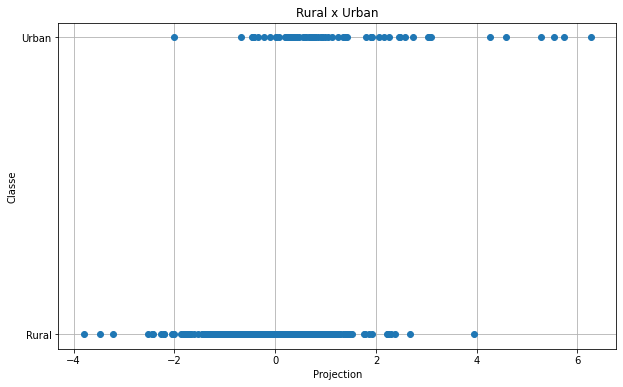

precision    recall  f1-score   support

       Rural       0.90      0.96      0.93       469
       Urban       0.47      0.23      0.31        64

    accuracy                           0.88       533
   macro avg       0.69      0.60      0.62       533
weighted avg       0.85      0.88      0.86       533



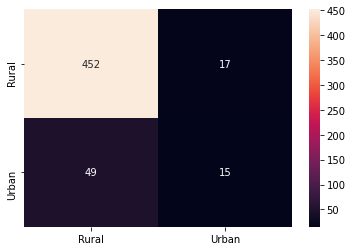

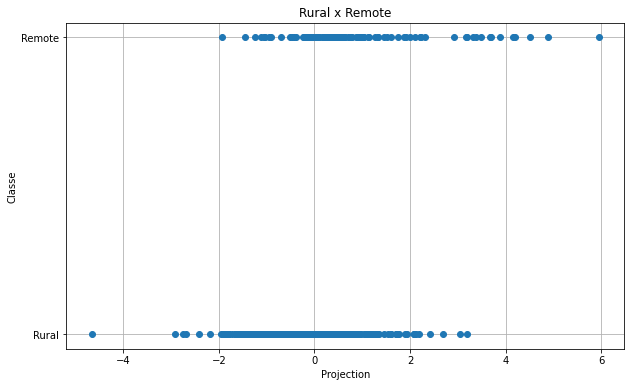

precision    recall  f1-score   support

      Remote       0.39      0.14      0.20        95
       Rural       0.85      0.96      0.90       469

    accuracy                           0.82       564
   macro avg       0.62      0.55      0.55       564
weighted avg       0.77      0.82      0.78       564



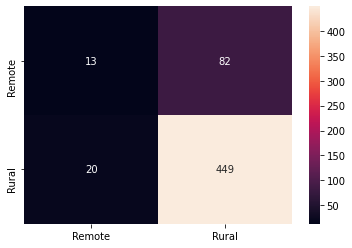

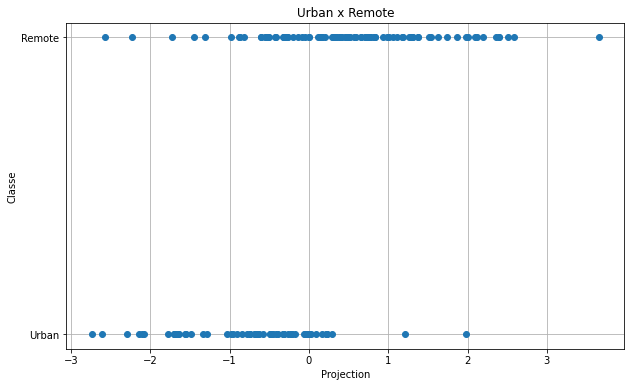

precision    recall  f1-score   support

      Remote       0.70      0.68      0.69        95
       Urban       0.55      0.56      0.55        64

    accuracy                           0.64       159
   macro avg       0.62      0.62      0.62       159
weighted avg       0.64      0.64      0.64       159



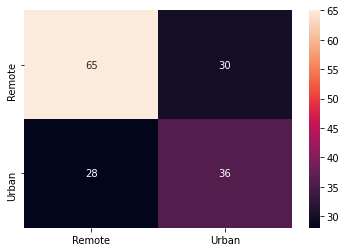

In [13]:
df_methodeC = df_epa_bdf.copy()
df_analyse_final = df_methodeC.dropna()
list_areas = pd.unique(df_analyse_final["Type"])
for (i, area_i) in enumerate(list_areas):
    for (j, area_j) in enumerate(list_areas):
        if (i < j):
            data = df_analyse_final[(df_analyse_final["Type"] == area_i) | (df_analyse_final["Type"] == area_j)]
            X = data[PRO_C]
            y = data["Type"]

            enc = LabelEncoder()
            label_encoder = enc.fit(y)
            y = label_encoder.transform(y) + 1
            label_dict = {a : b for (a, b) in zip(pd.unique(y), pd.unique(data["Type"]))}
            sklearn_lda = LDA(n_components=len(pd.unique(y)) - 1)
            X_lda_sklearn = sklearn_lda.fit_transform(X, y)
            plt.figure(figsize=(10, 6))
            plt.plot(X_lda_sklearn, data["Type"], 'o')
            plt.title(area_i + " x " + area_j)
            plt.xlabel("Projection")
            plt.ylabel("Classe")
            plt.grid()
            plt.show()

            ax= plt.subplot()
            y_pred = cross_val_predict(sklearn_lda,X,y,cv=10)
            print(classification_report(y, y_pred, target_names=[label_dict[i] for i in sorted(label_dict.keys())]))
            sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='2.0f', ax = ax)
            ax.xaxis.set_ticklabels([label_dict[i] for i in sorted(label_dict.keys())])
            ax.yaxis.set_ticklabels([label_dict[i] for i in sorted(label_dict.keys())])

# Normalisation A x C

### LDA 2 à 2

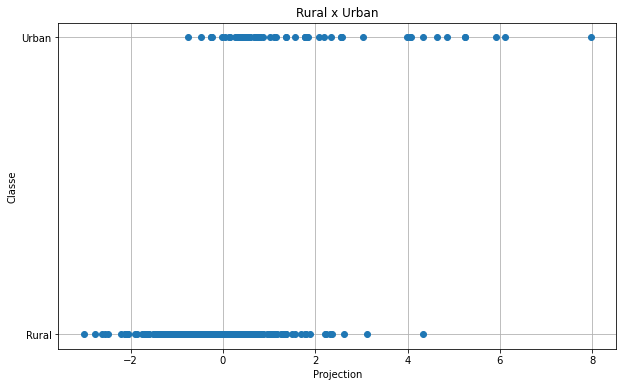

precision    recall  f1-score   support

       Rural       0.90      0.96      0.93       469
       Urban       0.44      0.25      0.32        64

    accuracy                           0.87       533
   macro avg       0.67      0.60      0.62       533
weighted avg       0.85      0.87      0.86       533



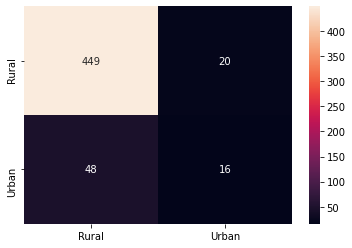

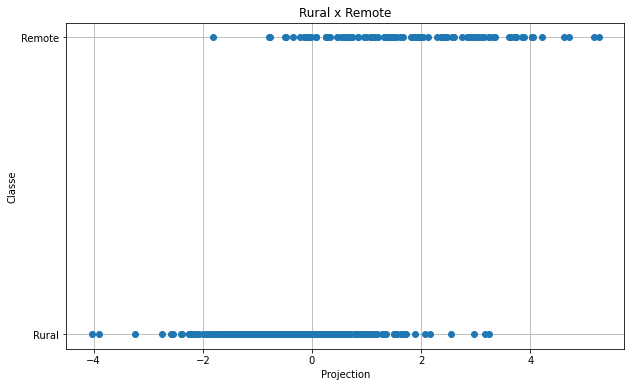

precision    recall  f1-score   support

      Remote       0.61      0.37      0.46        95
       Rural       0.88      0.95      0.92       469

    accuracy                           0.85       564
   macro avg       0.75      0.66      0.69       564
weighted avg       0.84      0.85      0.84       564



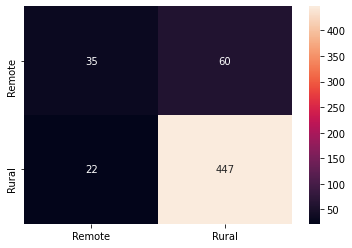

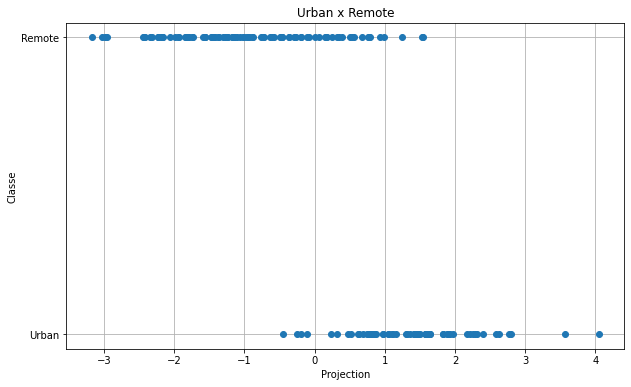

precision    recall  f1-score   support

      Remote       0.86      0.66      0.75        95
       Urban       0.63      0.84      0.72        64

    accuracy                           0.74       159
   macro avg       0.75      0.75      0.73       159
weighted avg       0.77      0.74      0.74       159



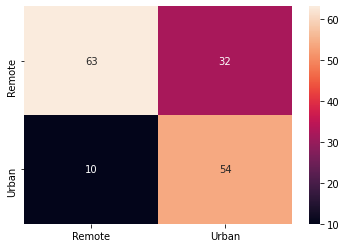

In [14]:
df_analyse_final = df_epa_bdf.dropna()
list_areas = pd.unique(df_analyse_final["Type"])
for (i, area_i) in enumerate(list_areas):
    for (j, area_j) in enumerate(list_areas):
        if (i < j):
            data = df_analyse_final[(df_analyse_final["Type"] == area_i) | (df_analyse_final["Type"] == area_j)]
            X = data[PRO_A + PRO_C]
            y = data["Type"]

            enc = LabelEncoder()
            label_encoder = enc.fit(y)
            y = label_encoder.transform(y) + 1
            label_dict = {a : b for (a, b) in zip(pd.unique(y), pd.unique(data["Type"]))}
            sklearn_lda = LDA(n_components=len(pd.unique(y)) - 1)
            X_lda_sklearn = sklearn_lda.fit_transform(X, y)
            plt.figure(figsize=(10, 6))
            plt.plot(X_lda_sklearn, data["Type"], 'o')
            plt.title(area_i + " x " + area_j)
            plt.xlabel("Projection")
            plt.ylabel("Classe")
            plt.grid()
            plt.show()

            ax= plt.subplot()
            y_pred = cross_val_predict(sklearn_lda,X,y,cv=10)
            print(classification_report(y, y_pred, target_names=[label_dict[i] for i in sorted(label_dict.keys())]))
            sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='2.0f', ax = ax)
            ax.xaxis.set_ticklabels([label_dict[i] for i in sorted(label_dict.keys())])
            ax.yaxis.set_ticklabels([label_dict[i] for i in sorted(label_dict.keys())])

### LDA globale

In [15]:
X = df_analyse_final[PRO_A + PRO_C]
y = df_analyse_final["Type"]
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
label_dict = {i : area for i, area in enumerate(list_areas)}

sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

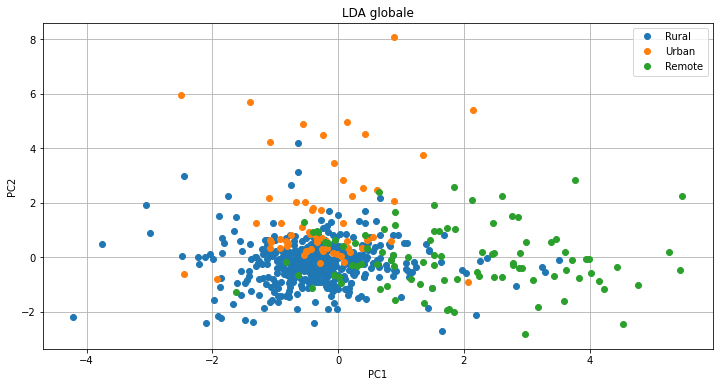

precision    recall  f1-score   support

           1       0.59      0.39      0.47        95
           2       0.81      0.92      0.86       469
           3       0.38      0.19      0.25        64

    accuracy                           0.77       628
   macro avg       0.59      0.50      0.53       628
weighted avg       0.73      0.77      0.74       628



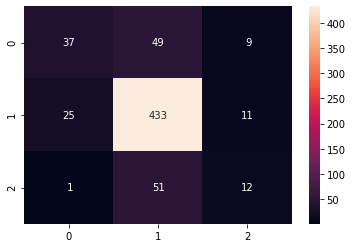

In [16]:
df_1 = []
df_2 = []
df_3 = []
plt.figure(figsize=(12, 6))
for (value, area) in zip(X_lda_sklearn, df_analyse_final["Type"]):
    if(area == "Rural"):
        df_1.append(list(value))
    elif(area == "Urban"):
        df_2.append(list(value))
    else:
        df_3.append(list(value))
plt.plot([i[0] for i in df_1], [i[1] for i in df_1], "o", label="Rural")
plt.plot([i[0] for i in df_2], [i[1] for i in df_2], "o", label="Urban")
plt.plot([i[0] for i in df_3], [i[1] for i in df_3], "o", label="Remote")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("LDA globale")
plt.grid()
plt.show()

y_pred = cross_val_predict(sklearn_lda,X,y,cv=10)
print(classification_report(y, y_pred))
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='2.0f')

## LDA sur les données bruit de fond et émission

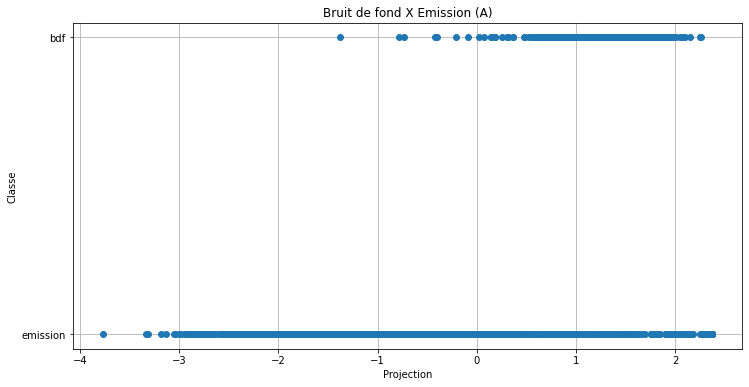

precision    recall  f1-score   support

         bdf       0.79      0.96      0.87       684
    emission       0.98      0.85      0.91      1167

    accuracy                           0.89      1851
   macro avg       0.88      0.91      0.89      1851
weighted avg       0.91      0.89      0.89      1851



[Text(0, 0.5, 'bdf'), Text(0, 1.5, 'emission')]

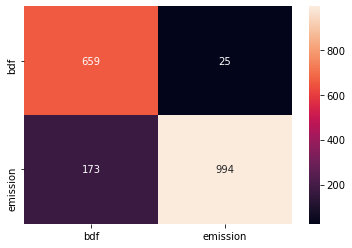

In [17]:
df_merge_final = df_merge[PRO_A + ["label"]]
df_merge_final = df_merge_final.dropna()
X = df_merge_final[PRO_A]
y = df_merge_final["label"]
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
label_dict = {i : area for i, area in zip(pd.unique(y), pd.unique(df_merge_final["label"]))}

sklearn_lda = LDA(n_components=1)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)
plt.figure(figsize=(12, 6))
plt.plot(X_lda_sklearn, df_merge_final["label"], 'o')
plt.title("Bruit de fond X Emission (A)")
plt.xlabel("Projection")
plt.ylabel("Classe")
plt.grid()
plt.show()
y_pred = cross_val_predict(sklearn_lda,X,y,cv=10)
print(classification_report(y, y_pred, target_names=[label_dict[i] for i in sorted(label_dict.keys())]))
ax= plt.subplot()
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='2.0f', ax = ax)
ax.xaxis.set_ticklabels([label_dict[i] for i in sorted(label_dict.keys())])
ax.yaxis.set_ticklabels([label_dict[i] for i in sorted(label_dict.keys())])

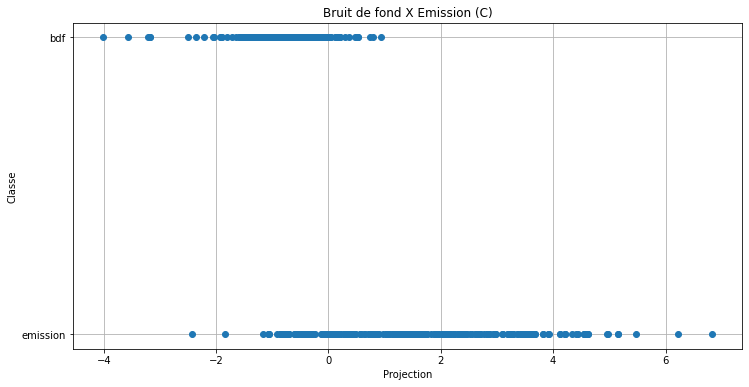

precision    recall  f1-score   support

         bdf       0.84      0.99      0.91       628
    emission       0.98      0.59      0.73       290

    accuracy                           0.86       918
   macro avg       0.91      0.79      0.82       918
weighted avg       0.88      0.86      0.85       918



[Text(0, 0.5, 'bdf'), Text(0, 1.5, 'emission')]

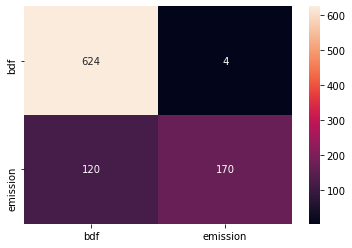

In [18]:
df_merge_final = df_merge[PRO_C + ["label"]]
df_merge_final = df_merge_final.dropna()
X = df_merge_final[PRO_C]
y = df_merge_final["label"]
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
label_dict = {i : area for i, area in zip(pd.unique(y), pd.unique(df_merge_final["label"]))}

sklearn_lda = LDA(n_components=1)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)
plt.figure(figsize=(12, 6))
plt.plot(X_lda_sklearn, df_merge_final["label"], 'o')
plt.title("Bruit de fond X Emission (C)")
plt.xlabel("Projection")
plt.ylabel("Classe")
plt.grid()
plt.show()
y_pred = cross_val_predict(sklearn_lda,X,y,cv=10)
print(classification_report(y, y_pred, target_names=[label_dict[i] for i in sorted(label_dict.keys())]))
ax= plt.subplot()
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='2.0f', ax = ax)
ax.xaxis.set_ticklabels([label_dict[i] for i in sorted(label_dict.keys())])
ax.yaxis.set_ticklabels([label_dict[i] for i in sorted(label_dict.keys())])

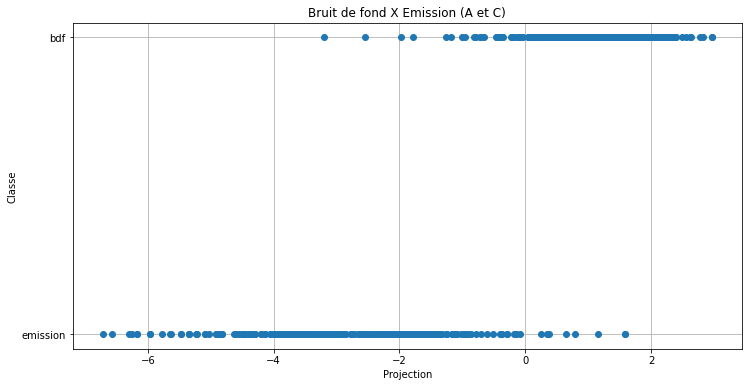

precision    recall  f1-score   support

         bdf       0.95      0.98      0.97       628
    emission       0.96      0.89      0.92       290

    accuracy                           0.95       918
   macro avg       0.95      0.93      0.94       918
weighted avg       0.95      0.95      0.95       918



[Text(0, 0.5, 'bdf'), Text(0, 1.5, 'emission')]

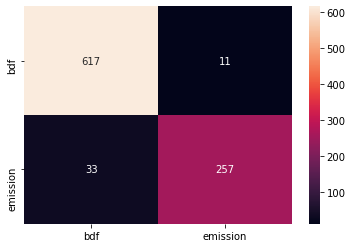

In [19]:
df_merge_final = df_merge[PRO_A + PRO_C + ["label"]]
df_merge_final = df_merge_final.dropna()
X = df_merge_final[PRO_A + PRO_C]
y = df_merge_final["label"]
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
label_dict = {i : area for i, area in zip(pd.unique(y), pd.unique(df_merge_final["label"]))}

sklearn_lda = LDA(n_components=1)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)
plt.figure(figsize=(12, 6))
plt.plot(X_lda_sklearn, df_merge_final["label"], 'o')
plt.title("Bruit de fond X Emission (A et C)")
plt.xlabel("Projection")
plt.ylabel("Classe")
plt.grid()
plt.show()
y_pred = cross_val_predict(sklearn_lda,X,y,cv=10)
print(classification_report(y, y_pred, target_names=[label_dict[i] for i in sorted(label_dict.keys())]))
ax= plt.subplot()
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='2.0f', ax = ax)
ax.xaxis.set_ticklabels([label_dict[i] for i in sorted(label_dict.keys())])
ax.yaxis.set_ticklabels([label_dict[i] for i in sorted(label_dict.keys())])

## LDA sur les données émission 

## LDA 2 à 2 custom

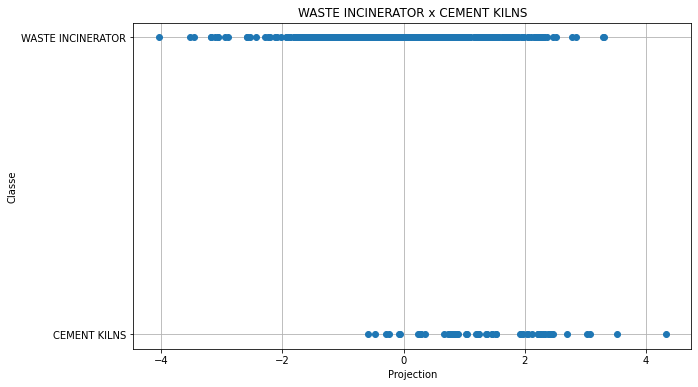

precision    recall  f1-score   support

           1       0.26      0.09      0.13        56
           2       0.95      0.99      0.97       986

    accuracy                           0.94      1042
   macro avg       0.61      0.54      0.55      1042
weighted avg       0.91      0.94      0.92      1042



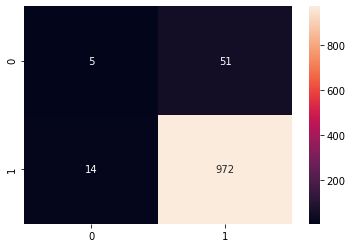

In [20]:
df_analyse_final = df_epa_emission.copy()
columns_analysis = PRO_A
list_source = pd.unique(df_epa_emission["source category"])
source_i = "WASTE INCINERATOR"
source_j = "CEMENT KILNS"
data = df_analyse_final[(df_analyse_final["source category"] == source_i) | (df_analyse_final["source category"] == source_j)][columns_analysis + ["source category"]].dropna()

X = data[columns_analysis]
y = data["source category"]

enc = LabelEncoder()
label_encoder = enc.fit(y)

y = label_encoder.transform(y) + 1
label_dict = {i:j for (i,j) in zip(pd.unique(y), pd.unique(label_encoder.inverse_transform(y - 1)))}

sklearn_lda = LDA(n_components=len(pd.unique(y)) - 1)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

plt.figure(figsize=(10, 6))
plt.plot(X_lda_sklearn, [label_dict[value] for value in y], 'o')
plt.title(source_i + " x " + source_j)
plt.xlabel("Projection")
plt.ylabel("Classe")
plt.grid()
plt.show()

y_pred = cross_val_predict(sklearn_lda,X,y,cv=10)
print(classification_report(y, y_pred))
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='2.0f')

## LDA 2 à 2 (normalisation A)

In [21]:
def color_false_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val == False else 'white'
    return 'color: %s' % color

## Source category

In [22]:
seuil = 0.8
result = []
df_analyse_final = df_epa_emission.copy()
list_source = pd.unique(df_epa_emission["source category"])
for (i, source_i) in enumerate(list_source):
    for (j, source_j) in enumerate(list_source):
        if (i < j):
            data = df_analyse_final[(df_analyse_final["source category"] == source_i) | (df_analyse_final["source category"] == source_j)][PRO_A + ["source category"]].dropna()

            X = data[PRO_A]
            y = data["source category"]

            enc = LabelEncoder()
            label_encoder = enc.fit(y)
            
            y = label_encoder.transform(y) + 1
            label_dict = {i:j for (i,j) in zip(pd.unique(y), pd.unique(label_encoder.inverse_transform(y - 1)))}

            sklearn_lda = LDA(n_components=len(pd.unique(y)) - 1)
            X_lda_sklearn = sklearn_lda.fit_transform(X, y)

            y_pred = sklearn_lda.predict(X)

            prediction = classification_report(y, y_pred, output_dict=True)
            if (prediction["1"]["precision"] >= seuil and prediction["2"]["precision"] >= seuil and prediction["1"]["recall"] >= seuil and prediction["2"]["recall"] >= seuil):
                result.append([source_i, source_j, True])
            else:
                result.append([source_i, source_j, False])

In [23]:
result_final = result.copy()
for data in result:
    result_final.append([data[1], data[0], data[2]])

df_result = pd.DataFrame(columns=["Source 1", "Source 2", "Value"], data = result_final)
pd.pivot_table(df_result, values='Value', index='Source 1', columns='Source 2').style.applymap(color_false_red)

Source 2,CEMENT KILNS,METAL SMELTING AND REFINING SOURCES,PETROLEUM REFINERY,POWER / ENERGY GENERATION,PPM,PULP AND PAPER MILLS,Unknown,WASTE INCINERATOR
Source 1,,,,,,,,
CEMENT KILNS,nan,True,True,False,False,False,False,False
METAL SMELTING AND REFINING SOURCES,True,nan,True,True,True,True,True,False
PETROLEUM REFINERY,True,True,nan,True,True,True,True,False
POWER / ENERGY GENERATION,False,True,True,nan,False,False,False,False
PPM,False,True,True,False,nan,False,False,False
PULP AND PAPER MILLS,False,True,True,False,False,nan,True,False
Unknown,False,True,True,False,False,True,nan,False
WASTE INCINERATOR,False,False,False,False,False,False,False,nan


## Source subcategory

In [24]:
seuil = 0.8
result = []
df_analyse_final = df_epa_emission.copy()
list_source = pd.unique(df_epa_emission["source subcategory"])
for (i, source_i) in enumerate(list_source):
    for (j, source_j) in enumerate(list_source):
        if (i < j):
            data = df_analyse_final[(df_analyse_final["source subcategory"] == source_i) | (df_analyse_final["source subcategory"] == source_j)][PRO_A + ["source subcategory"]].dropna()

            X = data[PRO_A]
            y = data["source subcategory"]

            enc = LabelEncoder()
            label_encoder = enc.fit(y)
            
            y = label_encoder.transform(y) + 1
            label_dict = {i:j for (i,j) in zip(pd.unique(y), pd.unique(label_encoder.inverse_transform(y - 1)))}

            sklearn_lda = LDA(n_components=len(pd.unique(y)) - 1)
            X_lda_sklearn = sklearn_lda.fit_transform(X, y)

            y_pred = sklearn_lda.predict(X)

            prediction = classification_report(y, y_pred, output_dict=True)
            if (prediction["1"]["precision"] >= seuil and prediction["2"]["precision"] >= seuil and prediction["1"]["recall"] >= seuil and prediction["2"]["recall"] >= seuil):
                result.append([source_i, source_j, True])
            else:
                result.append([source_i, source_j, False])

In [25]:
result_final = result.copy()
for data in result:
    result_final.append([data[1], data[0], data[2]])

df_result = pd.DataFrame(columns=["Source 1", "Source 2", "Value"], data = result_final)
pd.pivot_table(df_result, values='Value', index='Source 1', columns='Source 2').style.applymap(color_false_red)

Source 2,Bleached Chemical Wood Pulp and Paper Mills,Cement Kilns Burning and Not Burning Hazardous Waste,Coal Combustion - Utilities,Crematoria,Hazardous Waste Incineration,Industrial Wood Combustion,Kraft Black Liquor Recovery Boilers,Medical Waste Incineration,Municipal Solid Waste Incineration,Petroleum Refining Catalyst Regeneration,Primary Ferrous Metal Sintering Plants,Secondary Nonferrous Metal Smelting,Secondary Nonferrous Metal Smelting : Aluminium,Sewage Sludge Incineration,Tire Combustion,WRS,Wastewater Sludge at Bleached Chemical Pulp Mills
Source 1,,,,,,,,,,,,,,,,,
Bleached Chemical Wood Pulp and Paper Mills,nan,False,True,True,False,False,True,False,False,True,True,True,True,False,True,False,False
Cement Kilns Burning and Not Burning Hazardous Waste,False,nan,False,True,False,False,False,True,False,True,True,True,True,False,True,False,True
Coal Combustion - Utilities,True,False,nan,True,False,True,True,False,False,True,True,True,True,False,False,True,True
Crematoria,True,True,True,nan,False,True,True,True,False,True,True,True,True,True,True,True,True
Hazardous Waste Incineration,False,False,False,False,nan,False,False,False,False,False,True,False,False,False,False,False,False
Industrial Wood Combustion,False,False,True,True,False,nan,False,True,False,True,True,True,True,False,True,False,True
Kraft Black Liquor Recovery Boilers,True,False,True,True,False,False,nan,False,False,True,True,True,True,False,True,False,True
Medical Waste Incineration,False,True,False,True,False,True,False,nan,False,True,True,False,False,True,False,True,True
Municipal Solid Waste Incineration,False,False,False,False,False,False,False,False,nan,False,True,False,False,False,False,False,False


## LDA 2 à 2 (normalisation C)

## Source category

In [26]:
seuil = 0.8
result = []
df_analyse_final = df_epa_emission.copy()
list_source = pd.unique(df_epa_emission["source category"])
for (i, source_i) in enumerate(list_source):
    for (j, source_j) in enumerate(list_source):
        if (i < j):
            data = df_analyse_final[(df_analyse_final["source category"] == source_i) | (df_analyse_final["source category"] == source_j)][PRO_C + ["source category"]].dropna()

            X = data[PRO_C]
            y = data["source category"]

            enc = LabelEncoder()
            label_encoder = enc.fit(y)
            
            y = label_encoder.transform(y) + 1
            label_dict = {i:j for (i,j) in zip(pd.unique(y), pd.unique(label_encoder.inverse_transform(y - 1)))}

            sklearn_lda = LDA(n_components=len(pd.unique(y)) - 1)
            X_lda_sklearn = sklearn_lda.fit_transform(X, y)

            y_pred = sklearn_lda.predict(X)

            prediction = classification_report(y, y_pred, output_dict=True)
            if (prediction["1"]["precision"] >= seuil and prediction["2"]["precision"] >= seuil and prediction["1"]["recall"] >= seuil and prediction["2"]["recall"] >= seuil):
                result.append([source_i, source_j, True])
            else:
                result.append([source_i, source_j, False])

In [27]:
result_final = result.copy()
for data in result:
    result_final.append([data[1], data[0], data[2]])

df_result = pd.DataFrame(columns=["Source 1", "Source 2", "Value"], data = result_final)
pd.pivot_table(df_result, values='Value', index='Source 1', columns='Source 2').style.applymap(color_false_red)

Source 2,CEMENT KILNS,METAL SMELTING AND REFINING SOURCES,PETROLEUM REFINERY,POWER / ENERGY GENERATION,PPM,PULP AND PAPER MILLS,Unknown,WASTE INCINERATOR
Source 1,,,,,,,,
CEMENT KILNS,nan,True,True,True,True,True,True,False
METAL SMELTING AND REFINING SOURCES,True,nan,True,True,True,True,True,False
PETROLEUM REFINERY,True,True,nan,True,True,True,True,False
POWER / ENERGY GENERATION,True,True,True,nan,True,True,True,False
PPM,True,True,True,True,nan,True,True,False
PULP AND PAPER MILLS,True,True,True,True,True,nan,True,False
Unknown,True,True,True,True,True,True,nan,False
WASTE INCINERATOR,False,False,False,False,False,False,False,nan


## Source subcategory

In [28]:
seuil = 0.8
result = []
df_analyse_final = df_epa_emission.copy()
df_analyse_final = df_analyse_final[PRO_C + ["source subcategory"]].dropna()
list_source = pd.unique(df_analyse_final["source subcategory"])
for (i, source_i) in enumerate(list_source):
    for (j, source_j) in enumerate(list_source):
        if (i < j):
            data = df_analyse_final[(df_analyse_final["source subcategory"] == source_i) | (df_analyse_final["source subcategory"] == source_j)][PRO_C + ["source subcategory"]]

            X = data[PRO_C]
            y = data["source subcategory"]

            enc = LabelEncoder()
            label_encoder = enc.fit(y)
            
            y = label_encoder.transform(y) + 1
            label_dict = {i:j for (i,j) in zip(pd.unique(y), pd.unique(label_encoder.inverse_transform(y - 1)))}

            sklearn_lda = LDA(n_components=len(pd.unique(y)) - 1)
            X_lda_sklearn = sklearn_lda.fit_transform(X, y)

            y_pred = sklearn_lda.predict(X)

            prediction = classification_report(y, y_pred, output_dict=True)
            if (prediction["1"]["precision"] >= seuil and prediction["2"]["precision"] >= seuil and prediction["1"]["recall"] >= seuil and prediction["2"]["recall"] >= seuil):
                result.append([source_i, source_j, True])
            else:
                result.append([source_i, source_j, False])

In [29]:
result_final = result.copy()
for data in result:
    result_final.append([data[1], data[0], data[2]])

df_result = pd.DataFrame(columns=["Source 1", "Source 2", "Value"], data = result_final)
pd.pivot_table(df_result, values='Value', index='Source 1', columns='Source 2').style.applymap(color_false_red)

Source 2,Bleached Chemical Wood Pulp and Paper Mills,Cement Kilns Burning and Not Burning Hazardous Waste,Coal Combustion - Utilities,Crematoria,Hazardous Waste Incineration,Industrial Wood Combustion,Kraft Black Liquor Recovery Boilers,Medical Waste Incineration,Municipal Solid Waste Incineration,Petroleum Refining Catalyst Regeneration,Secondary Nonferrous Metal Smelting,Sewage Sludge Incineration,Tire Combustion,WRS,Wastewater Sludge at Bleached Chemical Pulp Mills
Source 1,,,,,,,,,,,,,,,
Bleached Chemical Wood Pulp and Paper Mills,nan,True,False,True,True,True,True,True,True,True,True,True,True,True,True
Cement Kilns Burning and Not Burning Hazardous Waste,True,nan,True,True,True,True,True,False,False,True,True,True,True,True,True
Coal Combustion - Utilities,False,True,nan,True,True,True,True,True,False,True,True,True,True,True,True
Crematoria,True,True,True,nan,True,True,True,True,True,True,True,True,True,True,True
Hazardous Waste Incineration,True,True,True,True,nan,True,True,True,True,True,True,True,True,True,True
Industrial Wood Combustion,True,True,True,True,True,nan,True,True,False,True,True,True,True,True,True
Kraft Black Liquor Recovery Boilers,True,True,True,True,True,True,nan,True,False,True,True,True,True,True,True
Medical Waste Incineration,True,False,True,True,True,True,True,nan,False,True,True,True,True,True,True
Municipal Solid Waste Incineration,True,False,False,True,True,False,False,False,nan,False,False,False,True,False,True


## LDA 2 à 2 (normalisation A et C)

In [30]:
seuil = 0.8
result = []
df_analyse_final = df_epa_emission.copy()
df_analyse_final = df_analyse_final[PRO_A + PRO_C + ["source category"]].dropna()
list_source = pd.unique(df_analyse_final["source category"])
for (i, source_i) in enumerate(list_source):
    for (j, source_j) in enumerate(list_source):
        if (i < j):
            data = df_analyse_final[(df_analyse_final["source category"] == source_i) | (df_analyse_final["source category"] == source_j)][PRO_A + PRO_C + ["source category"]].dropna()

            X = data[PRO_A + PRO_C]
            y = data["source category"]

            enc = LabelEncoder()
            label_encoder = enc.fit(y)
            
            y = label_encoder.transform(y) + 1
            label_dict = {i:j for (i,j) in zip(pd.unique(y), pd.unique(label_encoder.inverse_transform(y - 1)))}

            sklearn_lda = LDA(n_components=len(pd.unique(y)) - 1)
            X_lda_sklearn = sklearn_lda.fit_transform(X, y)

            y_pred = sklearn_lda.predict(X)

            prediction = classification_report(y, y_pred, output_dict=True)
            if (prediction["1"]["precision"] >= seuil and prediction["2"]["precision"] >= seuil and prediction["1"]["recall"] >= seuil and prediction["2"]["recall"] >= seuil):
                result.append([source_i, source_j, True])
            else:
                result.append([source_i, source_j, False])

In [31]:
result_final = result.copy()
for data in result:
    result_final.append([data[1], data[0], data[2]])

df_result = pd.DataFrame(columns=["Source 1", "Source 2", "Value"], data = result_final)
pd.pivot_table(df_result, values='Value', index='Source 1', columns='Source 2').style.applymap(color_false_red)

Source 2,CEMENT KILNS,METAL SMELTING AND REFINING SOURCES,PETROLEUM REFINERY,POWER / ENERGY GENERATION,PPM,PULP AND PAPER MILLS,Unknown,WASTE INCINERATOR
Source 1,,,,,,,,
CEMENT KILNS,nan,True,True,True,True,True,True,False
METAL SMELTING AND REFINING SOURCES,True,nan,True,True,True,True,True,False
PETROLEUM REFINERY,True,True,nan,True,True,True,True,False
POWER / ENERGY GENERATION,True,True,True,nan,True,True,True,False
PPM,True,True,True,True,nan,True,True,True
PULP AND PAPER MILLS,True,True,True,True,True,nan,True,True
Unknown,True,True,True,True,True,True,nan,True
WASTE INCINERATOR,False,False,False,False,True,True,True,nan


## Source subcatecory

In [32]:
seuil = 0.8
result = []
df_analyse_final = df_epa_emission.copy()
df_analyse_final = df_analyse_final[PRO_A + PRO_C + ["source subcategory"]].dropna()
list_source = pd.unique(df_analyse_final["source subcategory"])
for (i, source_i) in enumerate(list_source):
    for (j, source_j) in enumerate(list_source):
        if (i < j):
            data = df_analyse_final[(df_analyse_final["source subcategory"] == source_i) | (df_analyse_final["source subcategory"] == source_j)][PRO_A + PRO_C + ["source subcategory"]].dropna()

            X = data[PRO_A + PRO_C]
            y = data["source subcategory"]

            enc = LabelEncoder()
            label_encoder = enc.fit(y)
            
            y = label_encoder.transform(y) + 1
            label_dict = {i:j for (i,j) in zip(pd.unique(y), pd.unique(label_encoder.inverse_transform(y - 1)))}

            sklearn_lda = LDA(n_components=len(pd.unique(y)) - 1)
            X_lda_sklearn = sklearn_lda.fit_transform(X, y)

            y_pred = sklearn_lda.predict(X)

            prediction = classification_report(y, y_pred, output_dict=True)
            if (prediction["1"]["precision"] >= seuil and prediction["2"]["precision"] >= seuil and prediction["1"]["recall"] >= seuil and prediction["2"]["recall"] >= seuil):
                result.append([source_i, source_j, True])
            else:
                result.append([source_i, source_j, False])

In [33]:
result_final = result.copy()
for data in result:
    result_final.append([data[1], data[0], data[2]])

df_result = pd.DataFrame(columns=["Source 1", "Source 2", "Value"], data = result_final)
pd.pivot_table(df_result, values='Value', index='Source 1', columns='Source 2').style.applymap(color_false_red)

Source 2,Bleached Chemical Wood Pulp and Paper Mills,Cement Kilns Burning and Not Burning Hazardous Waste,Coal Combustion - Utilities,Crematoria,Hazardous Waste Incineration,Industrial Wood Combustion,Kraft Black Liquor Recovery Boilers,Medical Waste Incineration,Municipal Solid Waste Incineration,Petroleum Refining Catalyst Regeneration,Secondary Nonferrous Metal Smelting,Sewage Sludge Incineration,Tire Combustion,WRS,Wastewater Sludge at Bleached Chemical Pulp Mills
Source 1,,,,,,,,,,,,,,,
Bleached Chemical Wood Pulp and Paper Mills,nan,True,False,True,True,True,True,True,True,True,True,True,True,True,True
Cement Kilns Burning and Not Burning Hazardous Waste,True,nan,True,True,True,True,True,True,False,True,True,True,True,True,True
Coal Combustion - Utilities,False,True,nan,False,True,True,True,True,True,True,True,True,True,True,True
Crematoria,True,True,False,nan,True,True,True,True,True,True,True,True,True,True,True
Hazardous Waste Incineration,True,True,True,True,nan,True,True,True,True,True,True,True,True,True,True
Industrial Wood Combustion,True,True,True,True,True,nan,True,True,True,True,True,True,True,True,True
Kraft Black Liquor Recovery Boilers,True,True,True,True,True,True,nan,True,True,True,True,True,True,True,True
Medical Waste Incineration,True,True,True,True,True,True,True,nan,True,True,True,True,True,True,True
Municipal Solid Waste Incineration,True,False,True,True,True,True,True,True,nan,True,True,True,True,True,True


## LDA globale

In [34]:
df_epa_emission_final = df_epa_emission[PRO_A + ["source category"]].dropna()
X = df_epa_emission_final[PRO_A]
y = df_epa_emission_final["source category"]
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
label_dict = {i : area for i, area in enumerate(list_areas)}

sklearn_lda = LDA(n_components=len(pd.unique(df_epa_emission["source category"])) - 1)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

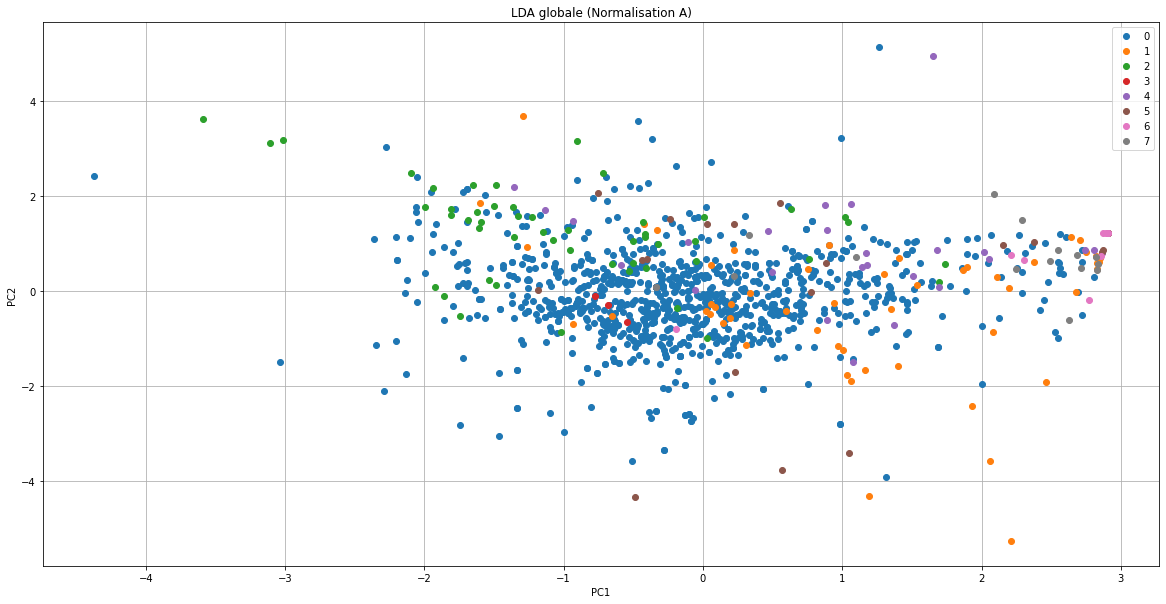

In [35]:
df_total = [[] for i in range(max(y))]
for (value, category) in zip(X_lda_sklearn, y):
    df_total[category - 1].append(value)

plt.figure(figsize=(20, 10))
for j in range(max(y)):
    plt.plot([i[0] for i in df_total[j-1]], [i[1] for i in df_total[j-1]], "o", label=str(j))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("LDA globale (Normalisation A)")
plt.grid()
plt.show()

In [36]:
df_epa_emission_final = df_epa_emission[PRO_C + ["source category"]].dropna()
X = df_epa_emission_final[PRO_C]
y = df_epa_emission_final["source category"]
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
label_dict = {i : area for i, area in enumerate(list_areas)}

sklearn_lda = LDA(n_components=len(pd.unique(df_epa_emission["source category"])) - 1)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

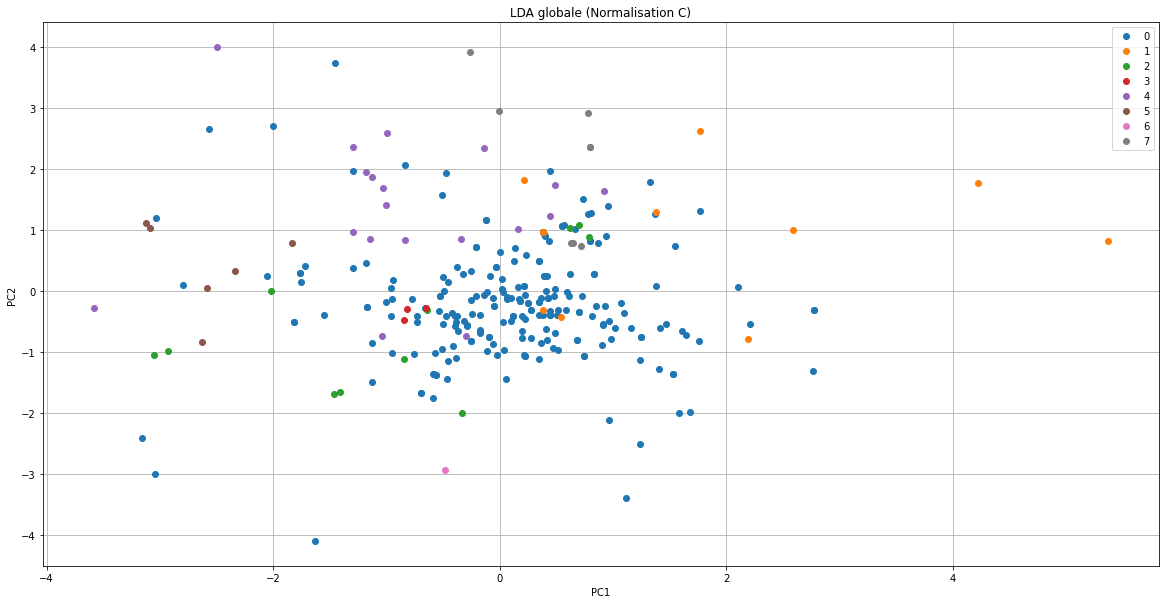

In [37]:
df_total = [[] for i in range(max(y))]
for (value, category) in zip(X_lda_sklearn, y):
    df_total[category - 1].append(value)

plt.figure(figsize=(20, 10))
for j in range(max(y)):
    plt.plot([i[0] for i in df_total[j-1]], [i[1] for i in df_total[j-1]], "o", label=str(j))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("LDA globale (Normalisation C)")
plt.grid()
plt.show()

In [38]:
df_epa_emission_final = df_epa_emission[PRO_A + PRO_C + ["source category"]].dropna()
X = df_epa_emission_final[PRO_A + PRO_C]
y = df_epa_emission_final["source category"]
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
label_dict = {i : area for i, area in enumerate(list_areas)}

sklearn_lda = LDA(n_components=len(pd.unique(df_epa_emission["source category"])) - 1)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

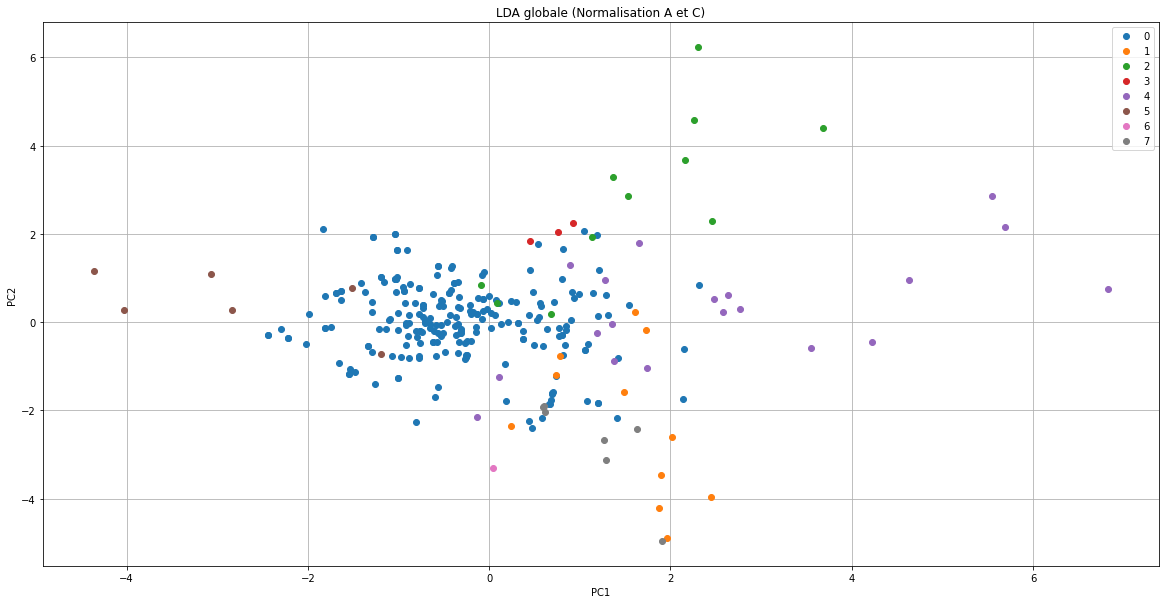

In [39]:
df_total = [[] for i in range(max(y))]
for (value, category) in zip(X_lda_sklearn, y):
    df_total[category - 1].append(value)

plt.figure(figsize=(20, 10))
for j in range(max(y)):
    plt.plot([i[0] for i in df_total[j-1]], [i[1] for i in df_total[j-1]], "o", label=str(j))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("LDA globale (Normalisation A et C)")
plt.grid()
plt.show()

In [40]:
df_epa_emission_final = df_epa_emission[PRO_A + PRO_C + ["source subcategory"]].dropna()
X = df_epa_emission_final[PRO_A + PRO_C]
y = df_epa_emission_final["source subcategory"]
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
label_dict = {i : area for i, area in enumerate(list_areas)}

sklearn_lda = LDA(n_components=len(pd.unique(df_epa_emission["source subcategory"])) - 1)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

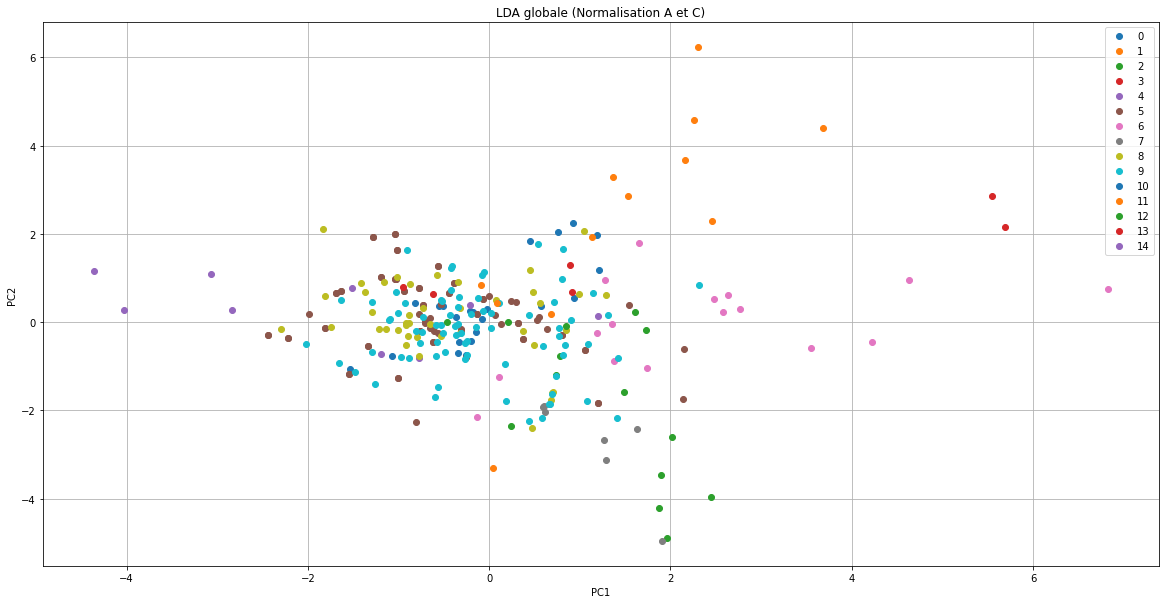

In [41]:
df_total = [[] for i in range(max(y))]
for (value, category) in zip(X_lda_sklearn, y):
    df_total[category - 1].append(value)

plt.figure(figsize=(20, 10))
for j in range(max(y)):
    plt.plot([i[0] for i in df_total[j-1]], [i[1] for i in df_total[j-1]], "o", label=str(j))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("LDA globale (Normalisation A et C)")
plt.grid()
plt.show()